In [1]:
%config Completer.use_jedi = False

import pandas as pd
import os
import subprocess
from video import Video
import random
from extractors import ExtractorFactory
from clusters import ClusterFactory

from mxnet import nd, gpu
import io
import cv2
import finch
from pathlib import Path

from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition.pca import PCA

import numpy as np
import math
from pprint import pprint
from accuracy import Accuracy
from npy import Npy

/home/guilherme/miniconda3/envs/as_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.decomposition.pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/guilherme/miniconda3/envs/as_env/lib/python3.7/site-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.7.0` and `torch==1.13.1+cu117` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '
/home/guilherme/unsup_action_seg_st_pe_embed/finch.py:14: UserWarning: pyflann not installed: No module named 'pyflann'
  warnings.warn('pyflann not installed: {}'.format(e))


### Breakfast dataset class

In [2]:
class Breakfast:
    
    def __init__(self):
        self.vd_root_folder = './BreakfastII_15fps_qvga_sync'
        self.gt_paths = self.__get_gt_paths()
#         self.i3d_feat_paths = self.__get_i3d_features_path()
        self.set_labels_mapping()
    
    def set_labels_mapping(self):
        action_set = []
        action_per_activity = {}
        for activity, gtpaths in self.gt_paths.items():
            action_per_activity[activity] = []
            for gtpath in gtpaths:
                gt_info = self.get_gt_info(gtpath)
                cur_actions = [seg['action'] for seg in gt_info]
                action_set.extend(cur_actions)
                action_per_activity[activity].extend(cur_actions)
            action_per_activity[activity] = set(action_per_activity[activity])
        action_set = list(set(action_set))
        action_set.sort()
        self.action_label_map = {action: i for i, action in enumerate(action_set)}
        self.action_label_map_per_activity = {activity: {action: self.action_label_map[action] for action in actions} for activity, actions in action_per_activity.items()}
    
    def __get_gt_paths(self):
        gt_paths = {}
        for path, subdirs, files in os.walk('segmentation_coarse'):
            split_path = path.split("/")
            if len(split_path) == 2:
                gt_paths[split_path[-1]] = []
                for name in files:
                    if name.split(".")[-1] == 'txt':
                        gt_paths[split_path[-1]].append(os.path.join(path, name))
        assert sum([len(paths) for _, paths in gt_paths.items()]) == 1712
        return gt_paths
    
    def __get_i3d_features_path(self):
        feat_paths = []
        for path, subdirs, files in os.walk('bf_kinetics_feat'):
            for name in files:
                feat_paths.append(os.path.join(path, name))

        breakfast = {}
        for path in feat_paths:
            b_type = path.split("_")[-1][:-4]
            breakfast[b_type] = breakfast.get(b_type, []) + [path]

        assert sum([len(paths) for _, paths in breakfast.items()]) == 1712
        
        return breakfast
    
    def gtpath_to_vdpath(self, gt_path):
        splitted_path = gt_path.split("/")[-1].split("_")
        pfolder = splitted_path[0]
        splitted_path[-1] = splitted_path[-1].split(".")[0]

        if 'stereo' in gt_path:
            recfolder = splitted_path[1][:-2]
            filename = "_".join([splitted_path[0], splitted_path[-1], 'ch1'])
            vd_path = "/".join([self.vd_root_folder, pfolder, recfolder, filename + '.avi'])
            if Path(vd_path).exists():
                return vd_path
            else:
                filename = "_".join([splitted_path[0], splitted_path[-1], 'ch0'])
                vd_path = "/".join([self.vd_root_folder, pfolder, recfolder, filename + '.avi'])
                return vd_path
        else:
            recfolder = splitted_path[1]
            filename = "_".join([splitted_path[0], splitted_path[-1]])

        return "/".join([self.vd_root_folder, pfolder, recfolder, filename + '.avi'])

    def get_gt_info(self, target_path):
        """ Reads the ground truth segments and convert them to a 32 fps video """

        target_gt_path = target_path

        if os.path.exists(target_gt_path) is False:
            return False

        with open(target_gt_path, 'r') as f:
            l1 = []
            for ele in f:
                line = ele.split('\n')
                annotation = line[0].rstrip()
                times, action = annotation.split(" ")
                start, end = times.split("-")
                if start == end:
                    continue

                if start == '1':
                    start = float(start)
                else:
                    if len(l1) == 0:
                        start = 1.
                    else:
                        start = float(l1[-1]['end']) + 1.

                l1.append(dict(start=start, end=float(end), action=action))
        return l1
    
    def gt_to_array(self, gt, video_len):
        """ Converts the ground truth dict to an array """
        frame_wise_gt = []
        n_segs = len(gt)

        for ith_class, gt_seg in enumerate(gt):
            start, end = gt_seg['start'], gt_seg['end']
            frame_wise_gt = frame_wise_gt + [self.action_label_map[gt_seg['action']]] * int(end - start + 1)

        return np.array(frame_wise_gt[:video_len])


bf = Breakfast()

### Segmentation evaluation class

In [3]:
class EvalSegmentation:
    
    def __init__(self):
        self.mofs = {}
        self.ious = {}
    
    def setup_key(self, key):
        self.mofs[key] = []
        self.ious[key] = []
        
    def __call__(self, predicted, ground_truth, key):
        acc = Accuracy()
        acc.predicted_labels = predicted
        acc.gt_labels = ground_truth
        acc.mof()
        acc.mof_classes()
        acc.iou_classes()
        stats = acc.stat()['iou']
        iou = stats[0] / stats[1]
        self.ious[key].append(iou)
        self.mofs[key].append(acc.mof_val())
    
    def get_gt2preds_mapping(self, gt, pred):
        acc = Accuracy()
        acc.predicted_labels = pred
        acc.gt_labels = gt
        return acc.get_gt2labels_mapping()
            
    def report_results(self):
        def calculate(metrics_per_key, metric_name):
            print(metric_name)
            acc_metric = []  # accumulated metric
            for key, metrics_per_sample in metrics_per_key.items():
                print(key, np.mean(metrics_per_sample))
                acc_metric.append(np.mean(metrics_per_sample))
            print(f"Final {metric_name}: {np.mean(acc_metric)}")
        calculate(self.ious, 'IoU')
        calculate(self.mofs, 'MoF')

_ = EvalSegmentation()

### Breakfast segmentation class

In [14]:
class SegmentBreakfast:
    
    def __init__(self, cluster_strategy: str, **kwargs):
        self.breakfast = Breakfast()
        self.cluster_strategy = cluster_strategy
        self.segmentator = ClusterFactory.get(cluster_strategy)(**kwargs)
        self.cluster_type = cluster_strategy
        self.segment_root_folder = './segments'
        self.eval = EvalSegmentation()
        self.npy = Npy()
    
    def map_seglabels_to_framelabels(self, labels, video_len, seg_len=32):
        """ Map segments(32 frames pieces of a video) labels to a framewise label """
        frames_labels = []

        for seg_label in labels:
            frames_labels = frames_labels + [seg_label] * seg_len
        return np.array(frames_labels[:video_len])
    
    def predpath_root(self, with_pe: bool, feature_extractor: str, frames_window_len: str) -> str:
        """ Creates the root folder of a action segmentation prediction """
        if with_pe:
            predroot_words = [self.segment_root_folder, "pe", feature_extractor, frames_window_len , self.cluster_type]
        else:
            predroot_words = [self.segment_root_folder, feature_extractor, frames_window_len, self.cluster_type]
        return "_".join(predroot_words)
    
    def gtpath_to_predpath(self, feat_path: str, with_pe: bool,
                           feature_extractor: str, frames_window_len: int) -> str:
        """ Transforms a breakfast ground truth path to a segments prediction path """
        gt_fname = feat_path.split("/")[-1]
        pred_fname = ".".join(gt_fname.split(".")[:-1] + ['npy'])
        return "/".join([self.predpath_root(with_pe=with_pe,
                                            feature_extractor=feature_extractor,
                                            frames_window_len=str(frames_window_len)),
                         pred_fname])
    
    def save_segment(self, predpath: str, seg_pred: np.ndarray) -> None:
        """ Save the segmentation prediction of a video in a path """
        *predpath_root, pred_fname = predpath.split("/")
        predpath_root = "/".join(predpath_root)
        self.npy.write(predpath_root, pred_fname, seg_pred)
    
    def get_video_from_gtpath(self, gt_path: str, input_len: int = 32, extraction_strategy: str = ExtractorFactory.SLOWFAST.value):
        """ Given the path to the ground truth information of a video this methods returns a Video object """
        vd_path = self.breakfast.gtpath_to_vdpath(gt_path)            
        video = Video(vd_path, "_".join([extraction_strategy, str(input_len)]))
        if extraction_strategy == ExtractorFactory.I3D.value:
            video.features = lambda with_pe: self.get_i3d_features(vd_path, with_pe=with_pe)
        return video
    
    def get_actionpred_from_gtpath(self,
                                   gt_path: str,
                                   feature_extractor: str,
                                   frames_window_len: int,
                                   with_pe: bool = True):
        """ Given the path to the ground truth information of a video this methods returns the predicted
            for this video
        """
        pred_path = self.gtpath_to_predpath(gt_path, with_pe,
                                            feature_extractor,
                                            frames_window_len)
        return np.load(pred_path)
    
    def predict_single_video_with_slowfast(self, gt_path: str, pe: bool = True, frames_len: int = 128, red_dim=False):
        video = self.get_video_from_gtpath(gt_path, input_len=frames_len)
        features = video.features(with_pe=pe, reduce_dim=red_dim)

        if self.cluster_strategy == ClusterFactory.OPTICS.value:
            segments_pred = self.segmentator.auto(features, fps=video.fps, samples_frame_len=frames_len)
        else:
            segments_pred = self.segmentator.auto(features)
        
        predpath = self.gtpath_to_predpath(gt_path,
                                           with_pe=pe,
                                           feature_extractor=ExtractorFactory.SLOWFAST.value,
                                           frames_window_len=frames_len)
        self.save_segment(predpath, segments_pred)
                
        frames_pred = self.map_seglabels_to_framelabels(segments_pred, len(video))
        
        gt_info = self.breakfast.get_gt_info(gt_path)
        gt = self.breakfast.gt_to_array(gt_info, len(video))
        
        if gt.shape[0] > frames_pred.shape[0]:
            gt = gt[:frames_pred.shape[0]]
        elif gt.shape[0] < frames_pred.shape[0]:
            frames_pred = frames_pred[:gt.shape[0]]
                
        self.eval.setup_key('anything')
        self.eval(frames_pred, gt, 'anything')
        return gt, frames_pred
        
    
    def with_slowfast_features(self, pe: bool = True, frames_len: int = 32, red_dim: bool = True) -> None:
        """
        Generates the action segmentation of the Breakfast dataset with features extracted with the Slowfast
        model
        """
        for activity, gts in self.breakfast.gt_paths.items():
            self.eval.setup_key(activity)
            for i, gt_path in enumerate(gts):
                video = self.get_video_from_gtpath(gt_path, input_len=frames_len)
                features = video.features(with_pe=pe, reduce_dim=red_dim)
                
                if self.cluster_strategy == ClusterFactory.OPTICS.value:
                    segments_pred = self.segmentator.auto(features, fps=video.fps, samples_frame_len=frames_len)
                else:
                    segments_pred = self.segmentator.auto(features)
                
                predpath = self.gtpath_to_predpath(gt_path,
                                                   with_pe=pe,
                                                   feature_extractor=ExtractorFactory.SLOWFAST.value,
                                                   frames_window_len=frames_len)
                self.save_segment(predpath, segments_pred)
                
                frames_pred = self.map_seglabels_to_framelabels(segments_pred, len(video), frames_len)
                gt_info = self.breakfast.get_gt_info(gt_path)
                gt = self.breakfast.gt_to_array(gt_info, len(video))
                
                if gt.shape[0] > frames_pred.shape[0]:
                    gt = gt[:frames_pred.shape[0]]
                elif gt.shape[0] < frames_pred.shape[0]:
                    frames_pred = frames_pred[:gt.shape[0]]
                
                self.eval(frames_pred, gt, activity)
            print(f"Finished {activity}")
        self.eval.report_results()
    
    def with_dino_features(self, gt_path: str, activity:str, pe: bool = True, frames_len: int = 32):
        video = self.get_video_from_gtpath(gt_path, input_len=1, extraction_strategy=ExtractorFactory.DINO.value)
        features = video.features(with_pe=pe, avg=True, n_rows=frames_len)
        segments_pred = self.segmentator.auto(features)
        predpath = self.gtpath_to_predpath(
            gt_path, with_pe=pe, feature_extractor=ExtractorFactory.DINO.value,
            frames_window_len=frames_len
        )
        frames_pred = self.map_seglabels_to_framelabels(segments_pred, len(video), frames_len)
        gt_info = self.breakfast.get_gt_info(gt_path)
        gt = self.breakfast.gt_to_array(gt_info, len(video))
        print(gt.shape)
        print(frames_pred.shape)
        if gt.shape[0] > frames_pred.shape[0]:
            gt = gt[:frames_pred.shape[0]]
        elif gt.shape[0] < frames_pred.shape[0]:
            frames_pred = frames_pred[:gt.shape[0]]
        self.eval(frames_pred, gt, activity)
        
        
    def get_i3d_features(self, vd_path: str, frames_window_len: int = 10, with_pe: bool = True, red_dim: bool = True) -> np.ndarray:
        if frames_window_len == 10:
            to_i3d_features = 'i3d_features/i3d'
        else:
            to_i3d_features = f'i3d_features_{frames_window_len}frames/i3d'

        *path, vd_name = vd_path.split("/")
        path = '/'.join(path)
        vd_name = vd_name.split(".")[0]
        
        flow = vd_name + '_flow.npy'
        rgb = vd_name + '_rgb.npy'

        path = '/'.join([path, to_i3d_features])        
        rgb_path = os.path.join(path, rgb)
        flow_path = os.path.join(path, flow)
        
        def positional_encoding(data: np.ndarray) -> np.ndarray:
            def get_sinusoid_encoding_table(length, d_model):

                def cal_angle(position, hid_idx):
                    return position / np.power(10000, 2 * (hid_idx // 2) / d_model)

                def get_posi_angle_vec(position):
                    return [cal_angle(position, hid_j) for hid_j in range(d_model)]

                sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(length)])

                sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
                sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

                return sinusoid_table

            d_model = data.shape[1]
            length = data.shape[0]

            pe = get_sinusoid_encoding_table(length, d_model)

            return data + pe

        data = np.concatenate([np.load(flow_path), np.load(rgb_path)], axis=1)
        
        if red_dim:
            reducer = PCA(n_components=.999999999)
            data = reducer.fit_transform(data)
        
        if with_pe:
            data = positional_encoding(data)
                
        return data

    def with_i3d_features(self, pe: str = 'SUM', frames_window_len: int=10, red_dim: bool = True):
        for activity, gts in self.breakfast.gt_paths.items():
            print(activity)
            self.eval.setup_key(activity)
            for gt_path in gts:
                # getting the video path
                vd_path = self.breakfast.gtpath_to_vdpath(gt_path)
                
                # getting the numpy array with the features of current path
                features = self.get_i3d_features(vd_path,
                                                 frames_window_len=frames_window_len,
                                                 with_pe=pe, red_dim=red_dim)
                video = Video(vd_path, ExtractorFactory.I3D.value)
                
                segments_pred = self.segmentator.auto(features)

                predpath = self.gtpath_to_predpath(gt_path,
                                                   with_pe=pe,
                                                   feature_extractor=ExtractorFactory.I3D.value,
                                                   frames_window_len=frames_window_len)
                self.save_segment(predpath, segments_pred)
                
                frames_pred = self.map_seglabels_to_framelabels(segments_pred,
                                                                len(video),
                                                                seg_len=frames_window_len)
                gt_info = self.breakfast.get_gt_info(gt_path)
                gt = self.breakfast.gt_to_array(gt_info, len(video))

                if gt.shape[0] > frames_pred.shape[0]:
                    gt = gt[:frames_pred.shape[0]]
                elif gt.shape[0] < frames_pred.shape[0]:
                    frames_pred = frames_pred[:gt.shape[0]]
                
                self.eval(frames_pred, gt, activity)
        self.eval.report_results()

### Dino

In [15]:
gt_path = "./segmentation_coarse/milk/P05_stereo01_P05_milk.txt"
segment_bf = SegmentBreakfast(ClusterFactory.FINCH.value, distance='euclidean')
segment_bf.eval.setup_key("milk")
segment_bf.with_dino_features(gt_path, "milk")
segment_bf.eval.report_results()

(1084, 768)
(34, 768)
(1084,)
(1084,)
IoU
milk 0.1920259774216371
Final IoU: 0.1920259774216371
MoF
milk 0.4621771217712177
Final MoF: 0.4621771217712177


### I3D - 10 frames window

#### FINCH

In [41]:
segment_bf = SegmentBreakfast(ClusterFactory.FINCH.value, distance='euclidean')
segment_bf.with_i3d_features()

scrambledegg
milk
coffee
salat
cereals
juice
sandwich
friedegg
pancake
tea
IoU
scrambledegg 0.21937542909717062
milk 0.30921512078497077
coffee 0.4322968158773649
salat 0.2613176588049729
cereals 0.3580702397814587
juice 0.3011474732121522
sandwich 0.2789197351987924
friedegg 0.2571947464568169
pancake 0.1668299105850468
tea 0.38388753594767266
Final IoU: 0.2968254665746418
MoF
scrambledegg 0.4949192158464852
milk 0.5244504466980825
coffee 0.5932198675179373
salat 0.5215507099952937
cereals 0.5712463457451351
juice 0.5623120800695203
sandwich 0.5169724101836979
friedegg 0.5361555408150339
pancake 0.5036918519491796
tea 0.5653357256543338
Final MoF: 0.5389854194474699


In [42]:
segment_bf = SegmentBreakfast(ClusterFactory.FINCH.value, distance='euclidean')
segment_bf.with_i3d_features(pe=False)

scrambledegg
milk
coffee
salat
cereals
juice
sandwich
friedegg
pancake
tea
IoU
scrambledegg 0.18921414600451525
milk 0.3586381401231825
coffee 0.38705092654491946
salat 0.2616861021001436
cereals 0.330020909847416
juice 0.29897349362976666
sandwich 0.27733972591554495
friedegg 0.1818792565554949
pancake 0.13593884227256461
tea 0.3622921919317755
Final IoU: 0.2783033734925323
MoF
scrambledegg 0.5192310435540097
milk 0.5677711787875898
coffee 0.5629839777490341
salat 0.5943123601518914
cereals 0.5510214113225157
juice 0.5925421268980945
sandwich 0.5352234103438274
friedegg 0.4998700888900831
pancake 0.532318135156033
tea 0.5780269649720894
Final MoF: 0.5533300697825168


#### KMeans

In [43]:
segment_bf = SegmentBreakfast(ClusterFactory.KMEANS.value, n=2)
segment_bf.with_i3d_features()

scrambledegg
milk
coffee
salat
cereals
juice
sandwich
friedegg
pancake
tea
IoU
scrambledegg 0.24569211595374305
milk 0.2620244789776222
coffee 0.31612588656852963
salat 0.21936522865869
cereals 0.30220741730877027
juice 0.29982126096249584
sandwich 0.2624848347677802
friedegg 0.24499466624764243
pancake 0.2811480618743207
tea 0.31156620270372903
Final IoU: 0.27454301540233234
MoF
scrambledegg 0.13388516703773734
milk 0.2112780021556078
coffee 0.25785258659501503
salat 0.07832612589414847
cereals 0.2479994086857648
juice 0.17219602339900886
sandwich 0.16752833564208686
friedegg 0.10680440585064416
pancake 0.1258783673983448
tea 0.25165459263818196
Final MoF: 0.17534030152965402


In [44]:
segment_bf = SegmentBreakfast(ClusterFactory.KMEANS.value, n=2)
segment_bf.with_i3d_features(pe=False)

scrambledegg
milk
coffee
salat
cereals
juice
sandwich
friedegg
pancake
tea
IoU
scrambledegg 0.23773258179875392
milk 0.3926960642871622
coffee 0.41546744969680294
salat 0.3197975439885778
cereals 0.3684666238916662
juice 0.3759549375172653
sandwich 0.3554737014925459
friedegg 0.23509185812784084
pancake 0.18310478792763066
tea 0.4244680068499278
Final IoU: 0.33082535555781734
MoF
scrambledegg 0.5437315674665464
milk 0.5422928138423782
coffee 0.5107503183785457
salat 0.5547785338253038
cereals 0.49012816272827775
juice 0.641328629651066
sandwich 0.5360922744382969
friedegg 0.5067045394748768
pancake 0.52628453642531
tea 0.5555501513710838
Final MoF: 0.5407641527601685


##### Reducing dim

In [21]:
segment_bf = SegmentBreakfast(ClusterFactory.KMEANS.value, n=2)
segment_bf.with_i3d_features(pe=True, red_dim=True)

scrambledegg
milk
coffee
salat
cereals
juice
sandwich
friedegg
pancake
tea
IoU
scrambledegg 0.35699515527311915
milk 0.4508489984268366
coffee 0.4389378188120492
salat 0.32153315824803963
cereals 0.4162359325656134
juice 0.451835465666965
sandwich 0.42848261307652075
friedegg 0.3626075726093839
pancake 0.32705640704951616
tea 0.4549318497059475
Final IoU: 0.40094649714339914
MoF
scrambledegg 0.5281391961512378
milk 0.500689696572196
coffee 0.4848902498286102
salat 0.3145778233390751
cereals 0.47912362424917077
juice 0.5613876176790652
sandwich 0.44556943163730567
friedegg 0.3678887991689021
pancake 0.4179699490981002
tea 0.5326053228315147
Final MoF: 0.4632841710555177


### I3D - 16 frames window

#### FINCH

In [103]:
segment_bf = SegmentBreakfast(ClusterFactory.FINCH.value, distance='euclidean')
segment_bf.with_i3d_features(pe=True, frames_window_len=16)

scrambledegg
milk
coffee
salat
cereals
juice
sandwich
friedegg
pancake
tea
IoU
scrambledegg 0.2021908325168955
milk 0.3522475972634911
coffee 0.46249219627751786
salat 0.2731597363647072
cereals 0.37124268104834535
juice 0.29898742677512385
sandwich 0.30671439329001937
friedegg 0.24439101994861123
pancake 0.15103615830550693
tea 0.3873135086629669
Final IoU: 0.3049775550453185
MoF
scrambledegg 0.4736157185546958
milk 0.5698705690379768
coffee 0.6245376619738967
salat 0.5324945583257813
cereals 0.5991134733351065
juice 0.5647786368843444
sandwich 0.5463543419014931
friedegg 0.5541276287129175
pancake 0.5003372121897915
tea 0.5798002558843395
Final MoF: 0.5545030056800344


In [110]:
segment_bf = SegmentBreakfast(ClusterFactory.FINCH.value, distance='euclidean')
segment_bf.with_i3d_features(pe=False, frames_window_len=16)

scrambledegg
milk
coffee
salat
cereals
juice
sandwich
friedegg
pancake
tea
IoU
scrambledegg 0.18641729424570447
milk 0.3450914832053043
coffee 0.39245268985244264
salat 0.26097604017135506
cereals 0.33703464289510604
juice 0.26490938550865917
sandwich 0.2831137135371198
friedegg 0.1875153250704242
pancake 0.13970961794499093
tea 0.37042557360840217
Final IoU: 0.2767645766039509
MoF
scrambledegg 0.5079768791290823
milk 0.5533516881959863
coffee 0.5492418590011672
salat 0.584286730491668
cereals 0.5311341882126479
juice 0.5796906262132145
sandwich 0.5437091870429099
friedegg 0.4956623148063631
pancake 0.5222455901637358
tea 0.5614082407712337
Final MoF: 0.5428707304028008


#### KMeans

In [111]:
segment_bf = SegmentBreakfast(ClusterFactory.KMEANS.value, n=2)
segment_bf.with_i3d_features(pe=True, frames_window_len=16)

scrambledegg
milk
coffee
salat
cereals
juice
sandwich
friedegg
pancake
tea
IoU
scrambledegg 0.3123357621396277
milk 0.35150236033262117
coffee 0.3992055652382021
salat 0.2541750298302493
cereals 0.38746443015876075
juice 0.3911337584180293
sandwich 0.3298179719922048
friedegg 0.3194464137638651
pancake 0.30988775510837535
tea 0.4133540712149938
Final IoU: 0.346832311819693
MoF
scrambledegg 0.1910872899934587
milk 0.30721600196817583
coffee 0.36739164245087297
salat 0.10560871249486792
cereals 0.35627397188036763
juice 0.24443833914783125
sandwich 0.23485332421037883
friedegg 0.14627619348182969
pancake 0.1363776064113473
tea 0.3671198329762229
Final MoF: 0.2456642915015353


In [112]:
segment_bf = SegmentBreakfast(ClusterFactory.KMEANS.value, n=2)
segment_bf.with_i3d_features(pe=False, frames_window_len=16)

scrambledegg
milk
coffee
salat
cereals
juice
sandwich
friedegg
pancake
tea
IoU
scrambledegg 0.22712040199756284
milk 0.3777805305876598
coffee 0.3957559499356925
salat 0.32686563232221294
cereals 0.35287093931124874
juice 0.3660305101391983
sandwich 0.3370311050124223
friedegg 0.23655873211207973
pancake 0.1863587059982819
tea 0.41381987855703434
Final IoU: 0.32201923859733933
MoF
scrambledegg 0.5443319035706573
milk 0.5342097154865509
coffee 0.50829749295126
salat 0.5701761362207883
cereals 0.5005320185231016
juice 0.6294322044025641
sandwich 0.5256139463019233
friedegg 0.513016878669566
pancake 0.525805346228876
tea 0.5572947473122442
Final MoF: 0.5408710389667531


### I3D - 24 frames

#### FINCH

In [104]:
segment_bf = SegmentBreakfast(ClusterFactory.FINCH.value, distance='euclidean')
segment_bf.with_i3d_features(pe=True, frames_window_len=24)

scrambledegg
milk
coffee
salat
cereals
juice
sandwich
friedegg
pancake
tea
IoU
scrambledegg 0.22468778583148682
milk 0.3446077403728451
coffee 0.4368720936718192
salat 0.2712044253353242
cereals 0.36275746059365643
juice 0.332704134100771
sandwich 0.30999448826110826
friedegg 0.2966315853498777
pancake 0.20553044350944774
tea 0.42449817930911743
Final IoU: 0.3209488336335454
MoF
scrambledegg 0.5108255937895211
milk 0.5707358550480134
coffee 0.6109880685588212
salat 0.5177180389198852
cereals 0.5925708247890158
juice 0.5756459507554107
sandwich 0.5511577556601063
friedegg 0.5875919108477251
pancake 0.5087575065650904
tea 0.6072423336668681
Final MoF: 0.5633233838600458


In [105]:
segment_bf = SegmentBreakfast(ClusterFactory.FINCH.value, distance='euclidean')
segment_bf.with_i3d_features(pe=False, frames_window_len=24)

scrambledegg
milk
coffee
salat
cereals
juice
sandwich
friedegg
pancake
tea
IoU
scrambledegg 0.18138798829351416
milk 0.34498239429443833
coffee 0.411827896724777
salat 0.25689765691690253
cereals 0.33794986151037204
juice 0.24508864714163484
sandwich 0.27542476703499524
friedegg 0.180694284880978
pancake 0.1431020130742935
tea 0.4026730830673279
Final IoU: 0.2780028592939233
MoF
scrambledegg 0.49933887118636033
milk 0.5448514990696911
coffee 0.5724631722829714
salat 0.58292511409872
cereals 0.5349544596459055
juice 0.5626550641830533
sandwich 0.5328953907936755
friedegg 0.5008001532216425
pancake 0.541890073898244
tea 0.5771870076949915
Final MoF: 0.5449960806075256


### I3D - 32 frames

#### FINCH

In [240]:
segment_bf = SegmentBreakfast(ClusterFactory.FINCH.value, distance='euclidean')
segment_bf.with_i3d_features(pe=True, frames_window_len=32)

scrambledegg
milk
coffee
salat
cereals
juice
sandwich
friedegg
pancake
tea
IoU
scrambledegg 0.24057416016420333
milk 0.3493245757350147
coffee 0.4316797566212765
salat 0.275995895623317
cereals 0.394898782423432
juice 0.3579448545714763
sandwich 0.31569865719002926
friedegg 0.2819895510188504
pancake 0.20481846498829315
tea 0.4451489741768528
Final IoU: 0.3298073672512745
MoF
scrambledegg 0.5213979054036065
milk 0.5733457826649491
coffee 0.6390450751175081
salat 0.5119554326828593
cereals 0.6212432743123653
juice 0.6055949259674743
sandwich 0.571556168384594
friedegg 0.5598094528617238
pancake 0.5127093351298322
tea 0.6300158426129798
Final MoF: 0.5746673195137892


In [241]:
segment_bf = SegmentBreakfast(ClusterFactory.FINCH.value, distance='euclidean')
segment_bf.with_i3d_features(pe=False, frames_window_len=32)

scrambledegg
milk
coffee
salat
cereals
juice
sandwich
friedegg
pancake
tea
IoU
scrambledegg 0.18660488802702263
milk 0.36972829088682746
coffee 0.4229261892538202
salat 0.2627030060311495
cereals 0.3650357828288671
juice 0.25254765797244066
sandwich 0.28528184903860493
friedegg 0.180074011085736
pancake 0.14545973533730755
tea 0.3902196727737753
Final IoU: 0.2860581083235552
MoF
scrambledegg 0.5013731072097477
milk 0.5662908539832118
coffee 0.5940380875430484
salat 0.6018035619701078
cereals 0.5627242074963297
juice 0.5792203502307474
sandwich 0.5304315777843219
friedegg 0.49908893468098914
pancake 0.5297070415676083
tea 0.5755540750004486
Final MoF: 0.554023179746656


### I3D - 40 frames

#### FINCH

In [9]:
segment_bf = SegmentBreakfast(ClusterFactory.FINCH.value, distance='euclidean')
segment_bf.with_i3d_features(pe=True, frames_window_len=40, red_dim=False)

scrambledegg
milk
coffee
salat
cereals
juice
sandwich
friedegg
pancake
tea
IoU
scrambledegg 0.28295756323536353
milk 0.3658964044135728
coffee 0.45733853311524364
salat 0.28461638467039857
cereals 0.36325199778098477
juice 0.34572873642426816
sandwich 0.3139915128665103
friedegg 0.298863329363135
pancake 0.21567084254923355
tea 0.40451343970054454
Final IoU: 0.3332828744119255
MoF
scrambledegg 0.5490951305018168
milk 0.5842768770509109
coffee 0.6680670518325774
salat 0.5090788474054228
cereals 0.6149479592089859
juice 0.5900505065883787
sandwich 0.5697317542454393
friedegg 0.5621127416883952
pancake 0.5153882197443632
tea 0.6107450568761169
Final MoF: 0.5773494145142407


In [10]:
segment_bf = SegmentBreakfast(ClusterFactory.FINCH.value, distance='euclidean')
segment_bf.with_i3d_features(pe=False, frames_window_len=40, red_dim=False)

scrambledegg
milk
coffee
salat
cereals
juice
sandwich
friedegg
pancake
tea
IoU
scrambledegg 0.19344532955013097
milk 0.3748394677243293
coffee 0.42642600090077354
salat 0.2709563293718855
cereals 0.35792285400842144
juice 0.24683053203722993
sandwich 0.31128834475858475
friedegg 0.18625430500896906
pancake 0.15176136304686907
tea 0.405431832074263
Final IoU: 0.29251563584814566
MoF
scrambledegg 0.5254574573784433
milk 0.5742398880968389
coffee 0.5951981361946335
salat 0.5798371897882431
cereals 0.5774589522176302
juice 0.5715535500843135
sandwich 0.5437571333229426
friedegg 0.4968969078511716
pancake 0.5453491727089785
tea 0.59731800758161
Final MoF: 0.5607066395224806


### FINCH

#### I3D - 48 frames

In [12]:
segment_bf = SegmentBreakfast(ClusterFactory.FINCH.value, distance='euclidean')
segment_bf.with_i3d_features(pe=True, frames_window_len=48, red_dim=False)

scrambledegg
milk
coffee
salat
cereals
juice
sandwich
friedegg
pancake
tea
IoU
scrambledegg 0.2669622270664998
milk 0.36619033197419193
coffee 0.45188046386885644
salat 0.2892576316710857
cereals 0.3844357308187821
juice 0.3727100327141136
sandwich 0.3464650710256153
friedegg 0.3120171446192082
pancake 0.2511193544100761
tea 0.38901370394032797
Final IoU: 0.34300516921087576
MoF
scrambledegg 0.5344658088090563
milk 0.6009152124868639
coffee 0.660669756232083
salat 0.4738419991600415
cereals 0.6463413570508597
juice 0.5926095718604223
sandwich 0.5839335008464827
friedegg 0.5418254478872937
pancake 0.5307736117656676
tea 0.6100419110558748
Final MoF: 0.5775418177154645


In [9]:
segment_bf = SegmentBreakfast(ClusterFactory.FINCH.value, distance='euclidean')
segment_bf.with_i3d_features(pe=False, frames_window_len=48, red_dim=False)

scrambledegg
milk
coffee
salat
cereals
juice
sandwich
friedegg
pancake
tea
IoU
scrambledegg 0.1824915579226137
milk 0.40565532030451695
coffee 0.4553261635633942
salat 0.2678445839038869
cereals 0.3589322221916683
juice 0.26436889735101304
sandwich 0.3023692947650875
friedegg 0.18512751669269104
pancake 0.15755464724558962
tea 0.40781522546796184
Final IoU: 0.29874854294084235
MoF
scrambledegg 0.516725854224287
milk 0.6067808037127299
coffee 0.6524835973408804
salat 0.5946101038813856
cereals 0.5852480698960892
juice 0.5892995288409527
sandwich 0.5511848360285709
friedegg 0.5007797110919967
pancake 0.5350893399766907
tea 0.6105676846476716
Final MoF: 0.5742769529641254


#### I3D - 64 frames

In [11]:
segment_bf = SegmentBreakfast(ClusterFactory.FINCH.value, distance='euclidean')
segment_bf.with_i3d_features(pe=True, frames_window_len=64, red_dim=False)

scrambledegg
milk
coffee
salat
cereals
juice
sandwich
friedegg
pancake
tea
IoU
scrambledegg 0.35094466469508406
milk 0.3931244052476232
coffee 0.45475287249211566
salat 0.28491207127498647
cereals 0.34553524013338455
juice 0.37121101319015115
sandwich 0.36625661346213845
friedegg 0.31967583913325043
pancake 0.3095221961304784
tea 0.35695643778340524
Final IoU: 0.35528913535426176
MoF
scrambledegg 0.5686334871060843
milk 0.6360138567817593
coffee 0.684190071431604
salat 0.41496926521065647
cereals 0.6324606093607195
juice 0.5851137227522369
sandwich 0.5980685771719695
friedegg 0.505784288756637
pancake 0.5069256667982316
tea 0.6173228206937253
Final MoF: 0.5749482366063623


In [10]:
segment_bf = SegmentBreakfast(ClusterFactory.FINCH.value, distance='euclidean')
segment_bf.with_i3d_features(pe=False, frames_window_len=64, red_dim=False)

scrambledegg
milk
coffee
salat
cereals
juice
sandwich
friedegg
pancake
tea
IoU
scrambledegg 0.1800078699612604
milk 0.3997298432755986
coffee 0.4587230091076095
salat 0.26752119281576814
cereals 0.34414650885304726
juice 0.2687734358427447
sandwich 0.33075185995782524
friedegg 0.2053331147682564
pancake 0.15027052029843882
tea 0.3567227560584269
Final IoU: 0.2961980110938976
MoF
scrambledegg 0.5055273754362944
milk 0.6285175040539531
coffee 0.6690957578529402
salat 0.5793138576674712
cereals 0.6056809317913394
juice 0.5797236401405087
sandwich 0.573550785455343
friedegg 0.5167649137250405
pancake 0.5424050894092208
tea 0.598950579517204
Final MoF: 0.5799530435049316


### Slowfast

#### FINCH - 32

In [5]:
segment_bf = SegmentBreakfast(ClusterFactory.FINCH.value, distance='euclidean')
segment_bf.with_slowfast_features(pe=True, red_dim=False)

Finished scrambledegg
Finished milk
Finished coffee
Finished salat
Finished cereals
Finished juice
Finished sandwich
Finished friedegg
Finished pancake
Finished tea
IoU
scrambledegg 0.3872836046809749
milk 0.4452045108740749
coffee 0.4702470946652765
salat 0.32683334592092134
cereals 0.4050870649961108
juice 0.4109424237995928
sandwich 0.4019749735742902
friedegg 0.3949707733223815
pancake 0.33021242209567936
tea 0.4725235808261186
Final IoU: 0.40452797947554214
MoF
scrambledegg 0.4979556287335765
milk 0.593888785125077
coffee 0.641052027853303
salat 0.401320670012181
cereals 0.5997081816636226
juice 0.5399103840366323
sandwich 0.542970680135906
friedegg 0.4539529007459106
pancake 0.43824548151266385
tea 0.6135737706817119
Final MoF: 0.5322578510500584


In [6]:
segment_bf = SegmentBreakfast(ClusterFactory.FINCH.value, distance='euclidean')
segment_bf.with_slowfast_features(pe=False, red_dim=False)

Finished scrambledegg
Finished milk
Finished coffee
Finished salat
Finished cereals
Finished juice
Finished sandwich
Finished friedegg
Finished pancake
Finished tea
IoU
scrambledegg 0.17910730440437259
milk 0.34681125806534835
coffee 0.39999191205664386
salat 0.24918041308292846
cereals 0.34299084404784513
juice 0.2669801170377771
sandwich 0.2690645226206919
friedegg 0.19053535979465974
pancake 0.12971173872166816
tea 0.3809278474651084
Final IoU: 0.2755301317297044
MoF
scrambledegg 0.4954569915222257
milk 0.5566612562028692
coffee 0.5553917082762599
salat 0.5473122808882099
cereals 0.5489083284127471
juice 0.5801050729607882
sandwich 0.5211971755690568
friedegg 0.50300176255172
pancake 0.5171765229510886
tea 0.5735655083762751
Final MoF: 0.539877660771124


#### FINCH - 40

In [21]:
segment_bf = SegmentBreakfast(ClusterFactory.FINCH.value, distance='euclidean')
segment_bf.with_slowfast_features(pe=True, frames_len=40, red_dim=False)

Finished scrambledegg
Finished milk
Finished coffee
Finished salat
Finished cereals
Finished juice
Finished sandwich
Finished friedegg
Finished pancake
Finished tea
IoU
scrambledegg 0.332770372496813
milk 0.3894850492383093
coffee 0.46204904382372225
salat 0.2940922684563559
cereals 0.3912183192524095
juice 0.33277246003861877
sandwich 0.40698593795914056
friedegg 0.35038592322874357
pancake 0.3282653733383392
tea 0.40679044959629956
Final IoU: 0.36948151974287524
MoF
scrambledegg 0.5035543764678203
milk 0.5999355282099204
coffee 0.6378153237419106
salat 0.44126107473076637
cereals 0.6250545934732538
juice 0.5173847187703334
sandwich 0.5737174306768507
friedegg 0.47660246038874376
pancake 0.4840897987352521
tea 0.6161924314693366
Final MoF: 0.5475607736664189


In [178]:
segment_bf = SegmentBreakfast(ClusterFactory.FINCH.value, distance='euclidean')
segment_bf.with_slowfast_features(pe=False, frames_len=40, red_dim=False)

Finished scrambledegg
Finished milk
Finished coffee
Finished salat
Finished cereals
Finished juice
Finished sandwich
Finished friedegg
Finished pancake
Finished tea
IoU
scrambledegg 0.1754329460412568
milk 0.34710805609794865
coffee 0.39323352538900397
salat 0.24463026578526195
cereals 0.33584138884379205
juice 0.26403360389062386
sandwich 0.25549985656100516
friedegg 0.172932285366102
pancake 0.13919499814938452
tea 0.3664703538295595
Final IoU: 0.2694377279953938
MoF
scrambledegg 0.5065905012666967
milk 0.5482981637304515
coffee 0.5862080421277331
salat 0.5524592541163669
cereals 0.5451541901467974
juice 0.571154208554819
sandwich 0.5104357364012778
friedegg 0.4918303125059761
pancake 0.5195161425313164
tea 0.5576192081659923
Final MoF: 0.5389265759547428


#### FINCH - 48

In [216]:
segment_bf = SegmentBreakfast(ClusterFactory.FINCH.value, distance='euclidean')
segment_bf.with_slowfast_features(pe=True, frames_len=48, red_dim=False)

Finished scrambledegg
Finished milk
Finished coffee
Finished salat
Finished cereals
Finished juice
Finished sandwich
Finished friedegg
Finished pancake
Finished tea
IoU
scrambledegg 0.32339893394233105
milk 0.3792268503706952
coffee 0.4584698110509006
salat 0.30498484540712567
cereals 0.39423739311742184
juice 0.3489525217510502
sandwich 0.3532589815590539
friedegg 0.3496238513990536
pancake 0.29229003402754117
tea 0.3992442193850465
Final IoU: 0.36036874420102194
MoF
scrambledegg 0.536415396015695
milk 0.5971379067023246
coffee 0.6658970503607614
salat 0.4657423384168389
cereals 0.6312671601284291
juice 0.5708558540254424
sandwich 0.5679025953439955
friedegg 0.5292919387006801
pancake 0.48261489035325117
tea 0.6254306409937311
Final MoF: 0.567255577104115


In [217]:
segment_bf = SegmentBreakfast(ClusterFactory.FINCH.value, distance='euclidean')
segment_bf.with_slowfast_features(pe=False, frames_len=48, red_dim=False)

Finished scrambledegg
Finished milk
Finished coffee
Finished salat
Finished cereals
Finished juice
Finished sandwich
Finished friedegg
Finished pancake
Finished tea
IoU
scrambledegg 0.1805710375389745
milk 0.35379434834701884
coffee 0.37733209275119045
salat 0.24608821506876744
cereals 0.3361293378553069
juice 0.2801835288527378
sandwich 0.26667786589043047
friedegg 0.1799595562756373
pancake 0.13273859870644458
tea 0.35241899497936563
Final IoU: 0.2705893576265874
MoF
scrambledegg 0.4992683018693195
milk 0.5550578925518935
coffee 0.5891070898904247
salat 0.5632988249862979
cereals 0.5560507876608083
juice 0.5685658568846984
sandwich 0.5094569262340629
friedegg 0.5021208518166973
pancake 0.5049685026732921
tea 0.5592904515634575
Final MoF: 0.5407185486130952


#### FINCH - 64

In [213]:
segment_bf = SegmentBreakfast(ClusterFactory.FINCH.value, distance='euclidean')
segment_bf.with_slowfast_features(pe=True, frames_len=64, red_dim=False)

Finished scrambledegg
Finished milk
Finished coffee
Finished salat
Finished cereals
Finished juice
Finished sandwich
Finished friedegg
Finished pancake
Finished tea
IoU
scrambledegg 0.3073762140779771
milk 0.35344217217476426
coffee 0.42006496607800703
salat 0.28938197705911967
cereals 0.3359137579952796
juice 0.3148458901111698
sandwich 0.34287034143450434
friedegg 0.30477764168381155
pancake 0.258785896856805
tea 0.34754331978832326
Final IoU: 0.32750021772597615
MoF
scrambledegg 0.5505554974238108
milk 0.597161971770595
coffee 0.667152073191856
salat 0.4746047112799606
cereals 0.6137497633443735
juice 0.5724254928370236
sandwich 0.5917231748623143
friedegg 0.5304157967102517
pancake 0.5065976908649449
tea 0.6067806564318043
Final MoF: 0.5711166828716935


In [212]:
segment_bf = SegmentBreakfast(ClusterFactory.FINCH.value, distance='euclidean')
segment_bf.with_slowfast_features(pe=False, frames_len=64, red_dim=False)

Finished scrambledegg
Finished milk
Finished coffee
Finished salat
Finished cereals
Finished juice
Finished sandwich
Finished friedegg
Finished pancake
Finished tea
IoU
scrambledegg 0.17453424910472193
milk 0.3172769960618628
coffee 0.360842268112025
salat 0.23870055176777094
cereals 0.28842746430139465
juice 0.28390923807093177
sandwich 0.268484920660265
friedegg 0.1830144416342736
pancake 0.13782477391809822
tea 0.3181811771009594
Final IoU: 0.2571196080732303
MoF
scrambledegg 0.4887848337530459
milk 0.5503625397965588
coffee 0.5929952328237796
salat 0.5544017726962185
cereals 0.542025542584025
juice 0.5556718787593127
sandwich 0.5056382452350505
friedegg 0.49894827750382176
pancake 0.5152297448555769
tea 0.5615716932322351
Final MoF: 0.5365629761239625


#### FINCH - 72

In [305]:
segment_bf = SegmentBreakfast(ClusterFactory.FINCH.value, distance='euclidean')
segment_bf.with_slowfast_features(pe=True, frames_len=72, red_dim=False)

Finished scrambledegg
Finished milk
Finished coffee
Finished salat
Finished cereals
Finished juice
Finished sandwich
Finished friedegg
Finished pancake
Finished tea
IoU
scrambledegg 0.29306082456228405
milk 0.3363719164162829
coffee 0.41880782996157884
salat 0.2897706251022738
cereals 0.320938935124458
juice 0.31424084437146493
sandwich 0.34039153613467726
friedegg 0.3054963029437319
pancake 0.2601352496714273
tea 0.3379281167135741
Final IoU: 0.32171421810017525
MoF
scrambledegg 0.5393306071176451
milk 0.589828235899013
coffee 0.6734314141417587
salat 0.49938468292913357
cereals 0.6063654100936418
juice 0.5660454856481432
sandwich 0.6014568822649272
friedegg 0.5488463279199615
pancake 0.5142773806165052
tea 0.5987459152206044
Final MoF: 0.5737712341851333


In [306]:
segment_bf = SegmentBreakfast(ClusterFactory.FINCH.value, distance='euclidean')
segment_bf.with_slowfast_features(pe=False, frames_len=72, red_dim=False)

Finished scrambledegg
Finished milk
Finished coffee
Finished salat
Finished cereals
Finished juice
Finished sandwich
Finished friedegg
Finished pancake
Finished tea
IoU
scrambledegg 0.1773738890977334
milk 0.3149359969467909
coffee 0.3525413156025602
salat 0.24027617044397442
cereals 0.25986596513209137
juice 0.2776182968796403
sandwich 0.2785218132034357
friedegg 0.1808178675266909
pancake 0.12819397429773408
tea 0.31484438713976387
Final IoU: 0.2524989676270415
MoF
scrambledegg 0.5015556331416282
milk 0.5505793111919657
coffee 0.6087567043716879
salat 0.5550259917330548
cereals 0.5289440503976364
juice 0.5506186107450389
sandwich 0.5247052728808901
friedegg 0.4918504945393898
pancake 0.5161551836093423
tea 0.564401456828299
Final MoF: 0.5392592709438933


#### FINCH - 80

In [6]:
segment_bf = SegmentBreakfast(ClusterFactory.FINCH.value, distance='euclidean')
segment_bf.with_slowfast_features(pe=True, frames_len=80, red_dim=False)

Finished scrambledegg
Finished milk
Finished coffee
Finished salat
Finished cereals
Finished juice
Finished sandwich
Finished friedegg
Finished pancake
Finished tea
IoU
scrambledegg 0.26804789829450576
milk 0.32702367747319855
coffee 0.38571560846214925
salat 0.2790849323255816
cereals 0.31569891575109293
juice 0.3020432480660327
sandwich 0.32833489667338644
friedegg 0.30179761132690675
pancake 0.2588648790345288
tea 0.33692620588157135
Final IoU: 0.3103537873288954
MoF
scrambledegg 0.5402375463194679
milk 0.5867182100341428
coffee 0.6586642273187159
salat 0.49649328170104023
cereals 0.6060241377921064
juice 0.581902611249163
sandwich 0.5940168265763464
friedegg 0.5574091591311756
pancake 0.5166388115275651
tea 0.598310978649944
Final MoF: 0.5736415790299667


In [7]:
segment_bf = SegmentBreakfast(ClusterFactory.FINCH.value, distance='euclidean')
segment_bf.with_slowfast_features(pe=False, frames_len=80, red_dim=False)

Finished scrambledegg
Finished milk
Finished coffee
Finished salat
Finished cereals
Finished juice
Finished sandwich
Finished friedegg
Finished pancake
Finished tea
IoU
scrambledegg 0.18127788250436455
milk 0.29821333435587866
coffee 0.30173597016111725
salat 0.23575857948307857
cereals 0.25557765661100224
juice 0.2507109450801254
sandwich 0.2647575362701726
friedegg 0.18651445676093845
pancake 0.1344460178682411
tea 0.28609678194939486
Final IoU: 0.23950891610443134
MoF
scrambledegg 0.49700412903539093
milk 0.548367770465921
coffee 0.5751392833252488
salat 0.5416864501391122
cereals 0.5296813832625672
juice 0.5331568267503928
sandwich 0.5124752151124871
friedegg 0.48880489332379673
pancake 0.5127855107403552
tea 0.5540969411611034
Final MoF: 0.5293198403316375


#### FINCH - 128

In [211]:
segment_bf = SegmentBreakfast(ClusterFactory.FINCH.value, distance='euclidean')
segment_bf.with_slowfast_features(pe=True, frames_len=128, red_dim=False)

Finished scrambledegg
Finished milk
Finished coffee
Finished salat
Finished cereals
Finished juice
Finished sandwich
Finished friedegg
Finished pancake
Finished tea
IoU
scrambledegg 0.22606408734446928
milk 0.2523619104622577
coffee 0.29591706162990716
salat 0.25741306006115305
cereals 0.24708417751370623
juice 0.2424779722890587
sandwich 0.2818749633357193
friedegg 0.26425139999398317
pancake 0.21637618727343136
tea 0.23815893672749539
Final IoU: 0.2521979756631182
MoF
scrambledegg 0.5471715268682359
milk 0.5463959617863663
coffee 0.5975857366086481
salat 0.5112298277768745
cereals 0.5605675356842904
juice 0.5787351804843335
sandwich 0.5853529276585433
friedegg 0.5745286723556696
pancake 0.5409101129613765
tea 0.54367603699659
Final MoF: 0.5586153519180928


In [214]:
segment_bf = SegmentBreakfast(ClusterFactory.FINCH.value, distance='euclidean')
segment_bf.with_slowfast_features(pe=False, frames_len=128, red_dim=False)

Finished scrambledegg
Finished milk
Finished coffee
Finished salat
Finished cereals
Finished juice
Finished sandwich
Finished friedegg
Finished pancake
Finished tea
IoU
scrambledegg 0.17887603192560256
milk 0.2150544722588874
coffee 0.24744881317339598
salat 0.23972645073605764
cereals 0.1841385201899472
juice 0.21193374883483654
sandwich 0.23530711711910435
friedegg 0.18910238204687424
pancake 0.14547659180345193
tea 0.19494859068711556
Final IoU: 0.20420127187752737
MoF
scrambledegg 0.4889004398833366
milk 0.49803368832713585
coffee 0.5473367079576515
salat 0.5442198069516948
cereals 0.48455561102041994
juice 0.5396352909613192
sandwich 0.511793813275157
friedegg 0.48459495689754634
pancake 0.5153881969231698
tea 0.5062317277310492
Final MoF: 0.5120690239928481


In [7]:
segment_bf = SegmentBreakfast(ClusterFactory.FINCH.value, distance='euclidean')
segment_bf.with_slowfast_features(pe=True, red_dim=True)

Finished scrambledegg
Finished milk
Finished coffee
Finished salat
Finished cereals
Finished juice
Finished sandwich
Finished friedegg
Finished pancake
Finished tea
IoU
scrambledegg 0.1805697110305685
milk 0.3343652597413419
coffee 0.40756943598423057
salat 0.24000702034273327
cereals 0.3501542437927821
juice 0.25387087305363615
sandwich 0.2749980200569426
friedegg 0.21522406378411224
pancake 0.14595641356063274
tea 0.3830583904621289
Final IoU: 0.27857734318091093
MoF
scrambledegg 0.5244915774558692
milk 0.5486012309946191
coffee 0.5721713066842004
salat 0.5768389900121837
cereals 0.55291709892924
juice 0.5589664369133885
sandwich 0.5473585237226694
friedegg 0.5601431692847241
pancake 0.5458825125145493
tea 0.5653054150311292
Final MoF: 0.5552676261542573


In [8]:
segment_bf = SegmentBreakfast(ClusterFactory.FINCH.value, distance='euclidean')
segment_bf.with_slowfast_features(pe=False, red_dim=True)

Finished scrambledegg
Finished milk
Finished coffee
Finished salat
Finished cereals
Finished juice
Finished sandwich
Finished friedegg
Finished pancake
Finished tea
IoU
scrambledegg 0.17910730440437259
milk 0.34681125806534835
coffee 0.39999191205664386
salat 0.24918041308292846
cereals 0.34299084404784513
juice 0.2669801170377771
sandwich 0.2690645226206919
friedegg 0.19053535979465974
pancake 0.12971173872166816
tea 0.3809278474651084
Final IoU: 0.2755301317297044
MoF
scrambledegg 0.4954569915222257
milk 0.5566612562028692
coffee 0.5553917082762599
salat 0.5473122808882099
cereals 0.5489083284127471
juice 0.5801050729607882
sandwich 0.5211971755690568
friedegg 0.50300176255172
pancake 0.5171765229510886
tea 0.5735655083762751
Final MoF: 0.539877660771124


#### KMeans

In [7]:
segment_bf = SegmentBreakfast(ClusterFactory.KMEANS.value, n=2)
segment_bf.with_slowfast_features()

Finished scrambledegg
Finished milk
Finished coffee
Finished salat
Finished cereals
Finished juice
Finished sandwich
Finished friedegg
Finished pancake
Finished tea
IoU
scrambledegg 0.4031405023503865
milk 0.47926894864002023
coffee 0.49529531756032574
salat 0.30909745236720204
cereals 0.4848183060071934
juice 0.45806629466850357
sandwich 0.41694065719327383
friedegg 0.3996626139718952
pancake 0.39265838895090366
tea 0.5444500396248037
Final IoU: 0.4383398521334508
MoF
scrambledegg 0.29162553353380877
milk 0.47722752016189524
coffee 0.5440292746477214
salat 0.16849297250209042
cereals 0.527104532560911
juice 0.36664302417164557
sandwich 0.37168107562806646
friedegg 0.23314069400906215
pancake 0.2047648073763337
tea 0.5542872744751024
Final MoF: 0.37389967090666376


In [8]:
segment_bf = SegmentBreakfast(ClusterFactory.KMEANS.value, n=2)
segment_bf.with_slowfast_features(pe=False)

Finished scrambledegg
Finished milk
Finished coffee
Finished salat
Finished cereals
Finished juice
Finished sandwich
Finished friedegg
Finished pancake
Finished tea
IoU
scrambledegg 0.24679060606610095
milk 0.4399734233905062
coffee 0.4402146940239242
salat 0.31909811196789123
cereals 0.3835579756738492
juice 0.4035224459226943
sandwich 0.3528603469293504
friedegg 0.2314953544660336
pancake 0.18650186721636308
tea 0.4385576619381542
Final IoU: 0.3442572487594867
MoF
scrambledegg 0.5609875535545099
milk 0.5687127309120219
coffee 0.5634876716825576
salat 0.5603550862927439
cereals 0.5318377012041063
juice 0.6391334937169134
sandwich 0.5428628741205948
friedegg 0.5009351399052628
pancake 0.5336146762143683
tea 0.5741644175282903
Final MoF: 0.5576091345131369


### Visualizing embeddings

In [176]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from random import randint
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def reduce(features, n_components, algo):
    x_red = algo(n_components=n_components).fit_transform(features)
    return x_red    

def get_colors(pred):
    labels = list(np.unique(pred))
    colors = [hex for name, hex in mcolors.TABLEAU_COLORS.items()]
    return {label: colors[i] for i, label in enumerate(labels)}

def get_feat_and_preds(gt_path, cluster, extractor, window_len, pe):
    if cluster == 'KMEANS':
        seg_breakfast = SegmentBreakfast(cluster, n=2)
    else:
        seg_breakfast = SegmentBreakfast(cluster, distance='euclidean')
    video = seg_breakfast.get_video_from_gtpath(gt_path, input_len=window_len)
    features = video.features(with_pe=pe, reduce_dim=False)
    
    if extractor == 'I3D':
        vd_path = seg_breakfast.breakfast.gtpath_to_vdpath(gt_path)
        features = seg_breakfast.get_i3d_features(vd_path, frames_window_len=window_len, with_pe=pe)
    else:
        features = video.features(with_pe=pe)

    pred = seg_breakfast.get_actionpred_from_gtpath(gt_path, extractor,
                                                    window_len, pe)
    
    print(f'Number of predicted labels {len(np.unique(pred))}')
    gt = get_gt_mapped_to_segments(video, gt_path, window_len, seg_breakfast)
    return features, pred, gt

def get_gt_mapped_to_segments(video, gt_path, window_len, seg_breakfast):
    gt_info = seg_breakfast.breakfast.get_gt_info(gt_path)
    gt = seg_breakfast.breakfast.gt_to_array(gt_info, len(video))
    print(f'Number of ground truth labels {len(np.unique(gt))}')
    mapped = []
    for i in range(0, len(video), window_len):
        seg = gt[i: i + window_len - 1]
        labels, counts = np.unique(seg, return_counts=True)
        index = np.argmax(counts)
        label_mode = labels[index]
        mapped.append(label_mode)
        
    return np.array(mapped)
        
def plot_segmentation(features, predictions, algo=PCA, n_comp=3):
    features_red = reduce(features, n_components=n_comp, algo=algo)
    fig = plt.figure(figsize=(16, 9))
    ax = fig.add_subplot(111, projection='3d')
    colors = get_colors(predictions)

    for i, c in enumerate(features_red):
        label = predictions[i]
        ax.scatter(c[0], c[1], c[2], c=colors[label])

    plt.show()

Number of predicted labels 3
Number of ground truth labels 3
(8, 2304) (8,) (8,)


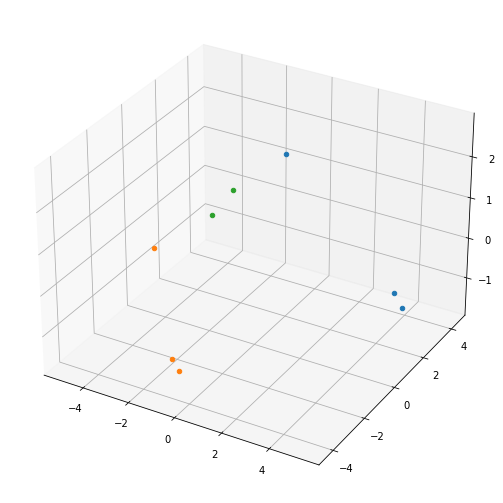

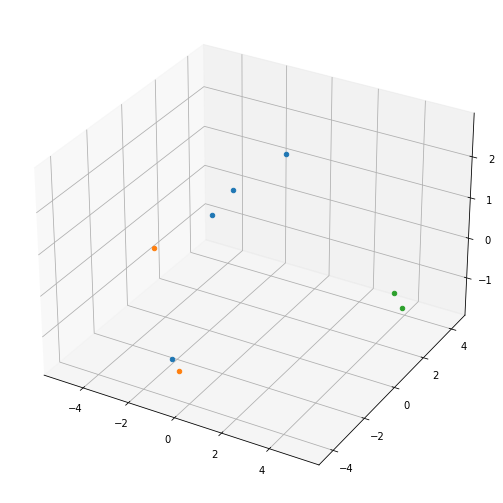

In [177]:
features, preds, gt = get_feat_and_preds(path, ClusterFactory.FINCH.value,
                                         ExtractorFactory.SLOWFAST.value, 64, False)
print(features.shape, preds.shape, gt.shape)
plot_segmentation(features, preds)
plot_segmentation(features, gt)

Number of predicted labels 2
Number of ground truth labels 4


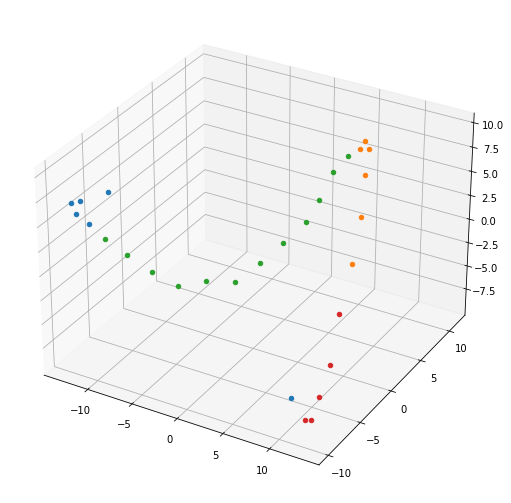

In [63]:
features, preds, gt = get_feat_and_preds(path, ClusterFactory.FINCH.value,
                                     ExtractorFactory.SLOWFAST.value, 32, True)
# plot_segmentation(features, preds)
plot_segmentation(features, gt)

Number of predicted labels 5
Number of ground truth labels 4


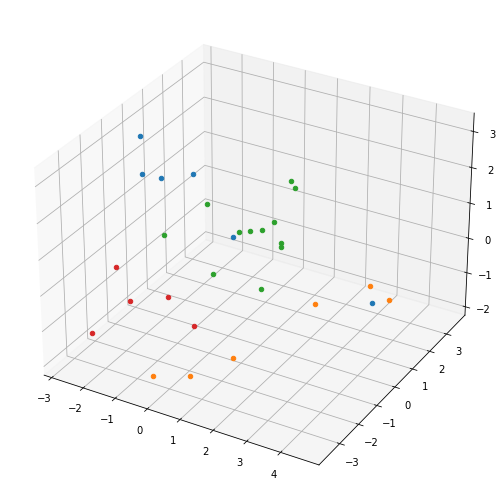

In [62]:
features, preds, gt = get_feat_and_preds(path, ClusterFactory.FINCH.value,
                                     ExtractorFactory.SLOWFAST.value, 32, False)
# plot_segmentation(features, preds)`
plot_segmentation(features, gt)

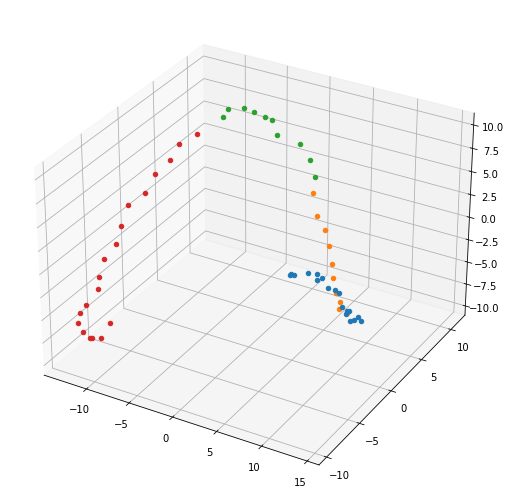

In [173]:
features, preds = get_feat_and_preds(juice_gt_path, ClusterFactory.FINCH.value,
                                     ExtractorFactory.I3D.value, 24, True)
plot_segmentation(features, preds)

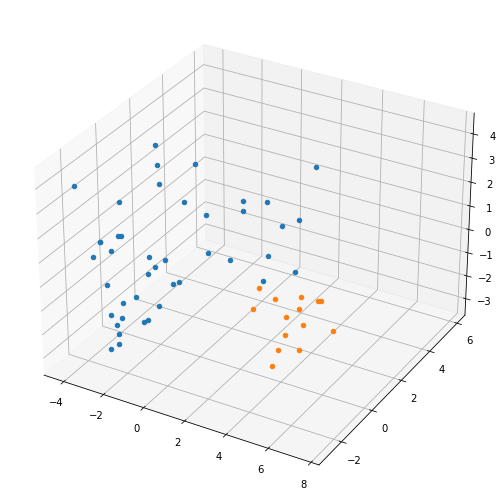

In [174]:
features, preds = get_feat_and_preds(juice_gt_path, ClusterFactory.FINCH.value,
                                     ExtractorFactory.I3D.value, 24, False)
plot_segmentation(features, preds)